## Self supervised large scale generalisation - Random adversarials  Pos to Neg

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
s3_prefixes = []


for (pre, t,p, m) in [
                 ("elfsup-adversariesrandomandpostonegs",2000, 500, 0), 
                 ("sup-adversariesrandomandpostonegs", 4000,1000,100), 
                 ("sup-adversariesrandomandpostonegs", 6000,1500, 150), 
                 ("sup-adversariesrandomandpostonegs", 8000,2000,200),
                 ("up-adversariesrandomandpostonegs", 10000,2500,250)]:
    for i in ["00", "01", "02", "03", "04"]:
        s3_prefixes.append(f"s3://aegovan-data/selfsupervised_chemprot/predictions_{pre}-{t}-{p}-{m}-{i}-202212302246/202301011118/")



In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)

    


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        

In [6]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [8]:


def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        df=df.pipe(self_label)
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "self_label"]])

 
    return  pd.concat(list_df_summary)




In [9]:
%%time 

from sklearn.metrics import precision_recall_fscore_support
import regex as re
import io, sagemaker

def create_stats_df(s3_prefix, confidence=0.0):
    print(f"Running {s3_prefix}, confidence {confidence}")

    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)
    df = get_summary_df (local_temp_pred_dir)


    total_predictions= len(df)
    df = df.query(f"confidence > {confidence} ")

    name = s3_prefix
    r = re.search(  "predictions_[a-z\-]+-(\d+)-(\d+)-(\d+)", s3_prefix)
    name= s3_prefix
    train_size= int(r.group(1))
    train_pos_size= int(r.group(2))
    train_adversarial =  int(r.group(3))
    prediction_above_threshold = len(df)

    p,r,f,s = precision_recall_fscore_support(df["self_label"], 
                         df["prediction"], pos_label = "True", average="binary", zero_division=0)
        
    return { "Name": name, 
                    "Precision":p * 100,
                    "Recall":r * 100,
                    "F1":f * 100,  
                  #  "Threshold": "HighConfidence", 
                    "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainAdversarial" : train_adversarial,
                        "TrainAdversarialRate" : 100.0 * train_adversarial/train_size,
                        "PredictionsSize": total_predictions, 
                   "PredictionsAboveThresholdSize": prediction_above_threshold,
                    "PredictionsAboveThresholdRatio" :prediction_above_threshold/total_predictions
           
           }
    
    

def create_stats_dfs_from_prefixes(s3_prefixes):
    result = [ create_stats_df(s, confidence=0.0) for s in s3_prefixes]
    df =  pd.DataFrame(result)
    return df

df_stats = create_stats_dfs_from_prefixes(s3_prefixes)

Running s3://aegovan-data/selfsupervised_chemprot/predictions_elfsup-adversariesrandomandpostonegs-2000-500-0-00-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_elfsup-adversariesrandomandpostonegs-2000-500-0-01-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_elfsup-adversariesrandomandpostonegs-2000-500-0-02-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_elfsup-adversariesrandomandpostonegs-2000-500-0-03-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_elfsup-adversariesrandomandpostonegs-2000-500-0-04-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_sup-adversariesrandomandpostonegs-4000-1000-100-00-202212302246/202301011118/, confidence 0.0
Running s3://aegovan-data/selfsupervised_chemprot/predictions_su

No handles with labels found to put in legend.


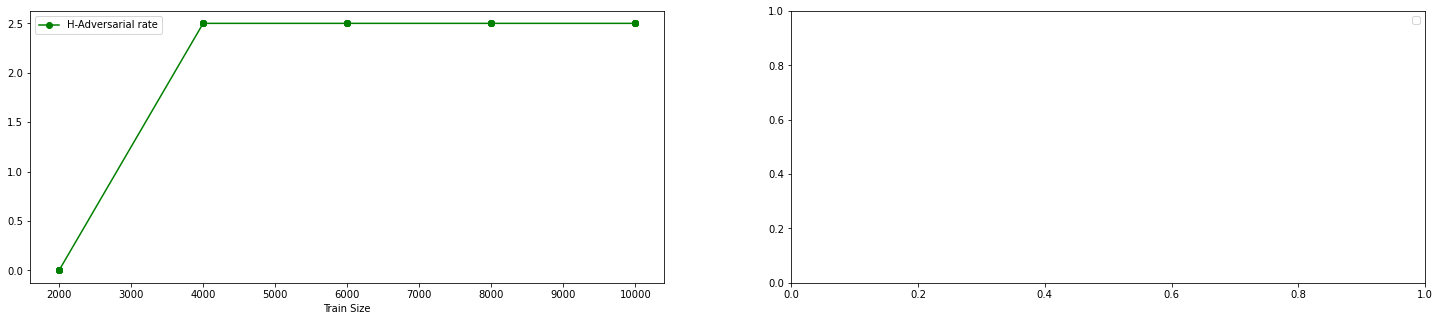

In [10]:
import warnings, matplotlib.pyplot as plt

def plot_comparison(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,2, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "TrainSize": "Train Size",
                        "Recall" : "Recall" , 
                        "F1": "F1" , 
                       }

        df[["TrainSize", "TrainAdversarialRate"]]\
            .rename(columns=column_renames)\
            .plot(x="Train Size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))

       
        plt.legend()

plot_comparison(df_stats)   

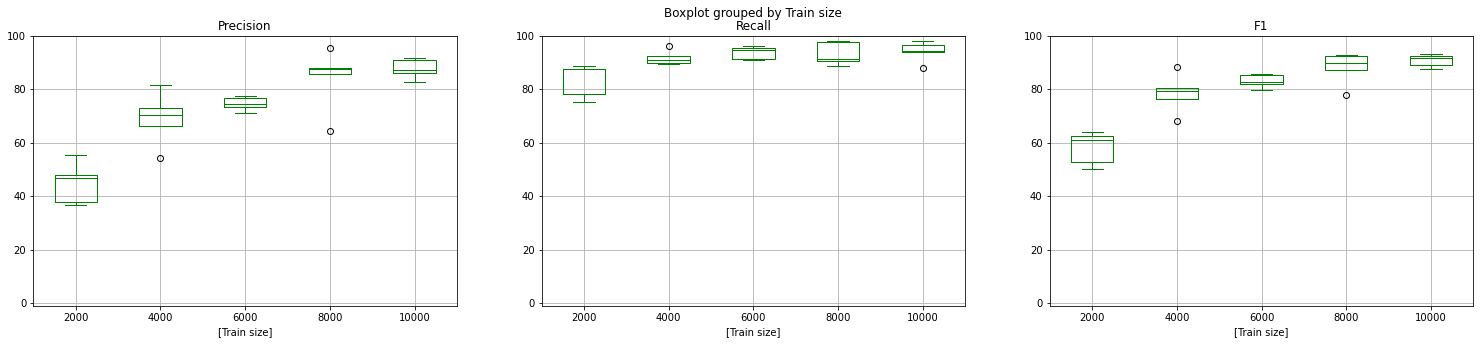

In [19]:
def plot_comparison_box(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,100)
        df[["Precision", "TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[0], color="green")

        ax[1].set_ylim(-1,100)
        df[["Recall","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[1], color="green")

        ax[2].set_ylim(-1,100)
        df[["F1","TrainSize"]]\
            .rename(columns=column_renames)\
            .boxplot(by="Train size",  ax=ax[2], color="green")

     
#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_box(df_stats)

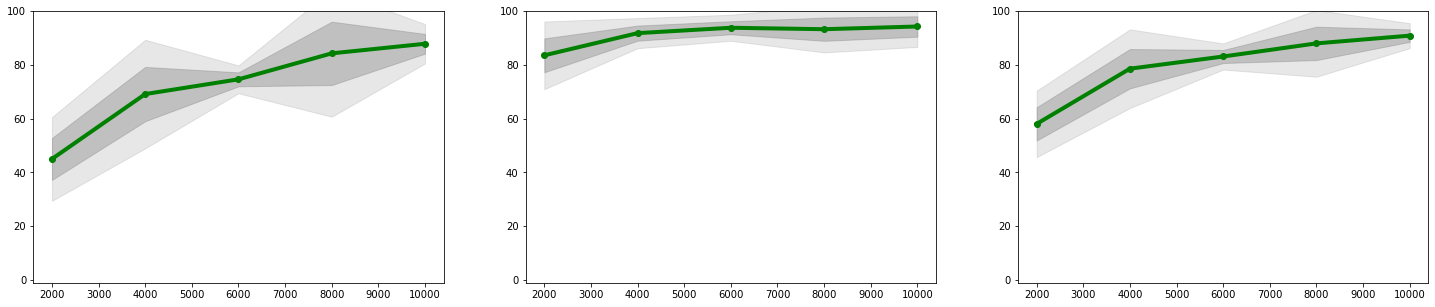

In [20]:
def plot_stdline(x, y_mean, y_std, ax, label):
    ax.plot(x, y_mean, color='green', label=label, linewidth = 4.0, marker='o')
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color='#888888', alpha=0.4)
    ax.fill_between(x, y_mean - 2*y_std, y_mean + 2*y_std, color='#888888', alpha=0.2)



def plot_comparison_linestd(df):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,3, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        
        linetype = "-"
        legend_suffix = ""


        column_renames={"Precision": "Precision" , 
                        "TrainSize" : "Train size" ,
                        "Recall" : "Recall" , 
                        "TrainAdversarialRate" : "H-Adversarial rate" ,
                        "F1": "F1" , 
                       }
        ax[0].set_ylim(-1,100)
        ldf = df.groupby("TrainSize")["Precision"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[0],  label='Precision')
       

        ax[1].set_ylim(-1,100)
        ldf = df.groupby("TrainSize")["Recall"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[1],  label='Recall')


        ax[2].set_ylim(-1,100)
        ldf = df.groupby("TrainSize")["F1"].describe()
        plot_stdline(ldf.index, ldf["mean"], ldf["std"], ax[2],  label='F1')

        



#         df[["TrainSize", "TrainAffableRate"]]\
#             .rename(columns=column_renames)\
#             .plot(x="Train size", linestyle =linetype, marker='o', ax=ax[0], color=(my_colors))


    
        #plt.legend()

plot_comparison_linestd(df_stats)

In [21]:
df_stats.groupby("TrainSize")[["Precision", "Recall", "F1"]].describe()



Precision                                                         \
              count       mean        std        min        25%        50%   
TrainSize                                                                    
2000            5.0  45.020422   7.776150  36.759054  37.949885  46.742578   
4000            5.0  69.138075  10.083758  54.164342  66.398798  70.480366   
6000            5.0  74.608475   2.584740  71.172570  73.267485  74.334230   
8000            5.0  84.260670  11.764828  64.285521  85.727988  87.710951   
10000           5.0  87.822267   3.658883  82.898797  86.137570  87.256789   

                                Recall             ...                        \
                 75%        max  count       mean  ...        75%        max   
TrainSize                                          ...                         
2000       48.080107  55.570486    5.0  83.530822  ...  87.745483  88.836979   
4000       72.895657  81.751210    5.0  91.773267  ...  92.305784  96.349279   
6000       76.754837  77.513254    5.0  93.773515  ...  95.617480  96.113615   
8000       88.100559  95.478329    5.0  93.233555  ...  97.556539  98.114690   
10000      90.950516  91.867664    5.0  94.242362  ...  96.622152  97.957581   

             F1                                                        \
          count       mean       std        min        25%        50%   
TrainSize                                                               
2000        5.0  58.057267  6.171767  50.031040  52.946398  60.993519   
4000        5.0  78.565595  7.303714  68.268966  76.238774  79.456651   
6000        5.0  83.092802  2.425220  79.862800  81.988614  82.641380   
8000        5.0  87.966304  6.195025  77.676672  87.180946  89.662314   
10000       5.0  90.842184  2.315066  87.662551  89.235939  91.668118   

                                 
                 75%        max  
TrainSize                        
2000       62.392381  63.922995  
4000       80.411607  88.451977  
6000       85.154093  85.817121  
8000       92.372135  92.939454  
10000      92.486536  93.157777  

[5 rows x 24 columns]

In [22]:
df_stats

,Name,Precision,Recall,F1,Support,TrainSize,TrainSizePositive,TrainAdversarial,TrainAdversarialRate,PredictionsSize,PredictionsAboveThresholdSize,PredictionsAboveThresholdRatio
0,s3://aegovan-data/selfsupervised_chemprot/pred...,36.759054,78.302394,50.031040,None,2000,500,0,0.0,500819,500819,1.0
1,s3://aegovan-data/selfsupervised_chemprot/pred...,48.080107,88.836979,62.392381,None,2000,500,0,0.0,500819,500819,1.0
2,s3://aegovan-data/selfsupervised_chemprot/pred...,46.742578,87.745483,60.993519,None,2000,500,0,0.0,500819,500819,1.0
3,s3://aegovan-data/selfsupervised_chemprot/pred...,37.949885,87.538760,52.946398,None,2000,500,0,0.0,500819,500819,1.0
4,s3://aegovan-data/selfsupervised_chemprot/pred...,55.570486,75.230496,63.922995,None,2000,500,0,0.0,500819,500819,1.0
5,s3://aegovan-data/selfsupervised_chemprot/pred...,72.895657,89.655600,80.411607,None,4000,1000,100,2.5,500819,500819,1.0
6,s3://aegovan-data/selfsupervised_chemprot/pred...,81.751210,96.349279,88.451977,None,4000,1000,100,2.5,500819,500819,1.0
7,s3://aegovan-data/selfsupervised_chemprot/pred...,54.164342,92.305784,68.268966,None,4000,1000,100,2.5,500819,500819,1.0
8,s3://aegovan-data/selfsupervised_chemprot/pred...,70.480366,91.053045,79.456651,None,4000,1000,100,2.5,500819,500819,1.0
9,s3://aegovan-data/selfsupervised_chemprot/pred...,66.398798,89.502625,76.238774,None,4000,1000,100,2.5,500819,500819,1.0


In [23]:
df_stats.groupby("TrainSize").describe().T

TrainSize                                     2000           4000   \
Precision                      count       5.000000       5.000000   
                               mean       45.020422      69.138075   
                               std         7.776150      10.083758   
                               min        36.759054      54.164342   
                               25%        37.949885      66.398798   
                               50%        46.742578      70.480366   
                               75%        48.080107      72.895657   
                               max        55.570486      81.751210   
Recall                         count       5.000000       5.000000   
                               mean       83.530822      91.773267   
                               std         6.289160       2.801004   
                               min        75.230496      89.502625   
                               25%        78.302394      89.655600   
                               50%        87.538760      91.053045   
                               75%        87.745483      92.305784   
                               max        88.836979      96.349279   
F1                             count       5.000000       5.000000   
                               mean       58.057267      78.565595   
                               std         6.171767       7.303714   
                               min        50.031040      68.268966   
                               25%        52.946398      76.238774   
                               50%        60.993519      79.456651   
                               75%        62.392381      80.411607   
                               max        63.922995      88.451977   
TrainSizePositive              count       5.000000       5.000000   
                               mean      500.000000    1000.000000   
                               std         0.000000       0.000000   
                               min       500.000000    1000.000000   
                               25%       500.000000    1000.000000   
                               50%       500.000000    1000.000000   
                               75%       500.000000    1000.000000   
                               max       500.000000    1000.000000   
TrainAdversarial               count       5.000000       5.000000   
                               mean        0.000000     100.000000   
                               std         0.000000       0.000000   
                               min         0.000000     100.000000   
                               25%         0.000000     100.000000   
                               50%         0.000000     100.000000   
                               75%         0.000000     100.000000   
                               max         0.000000     100.000000   
TrainAdversarialRate           count       5.000000       5.000000   
                               mean        0.000000       2.500000   
                               std         0.000000       0.000000   
                               min         0.000000       2.500000   
                               25%         0.000000       2.500000   
                               50%         0.000000       2.500000   
                               75%         0.000000       2.500000   
                               max         0.000000       2.500000   
PredictionsSize                count       5.000000       5.000000   
                               mean   500819.000000  500819.000000   
                               std         0.000000       0.000000   
                               min    500819.000000  500819.000000   
                               25%    500819.000000  500819.000000   
                               50%    500819.000000  500819.000000   
                               75%    500819.000000  500819.000000   
                               max    500819.000000  500819.000000   
Prediction

In [24]:
from scipy import stats


 
    
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Precision"], 
                df_stats.query("TrainSize == 2500")["Precision"])

Ttest_indResult(statistic=nan, pvalue=nan)

In [25]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["Recall"], 
                df_stats.query("TrainSize == 2500")["Recall"])

Ttest_indResult(statistic=nan, pvalue=nan)

In [26]:
stats.ttest_ind(df_stats.query("TrainSize == 2000")["F1"], 
                df_stats.query("TrainSize == 2500")["F1"])

Ttest_indResult(statistic=nan, pvalue=nan)